In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 加载所有CSV文件
def load_data(data_folder):
    data_frames = []
    for file in os.listdir(data_folder):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(data_folder, file), index_col=0, parse_dates=True)
            data_frames.append(df)
    return data_frames

# 数据预处理
def preprocess_data(df_list, time_window):
    x_data = []
    for df in df_list:
        df = df[['open', 'close', 'high', 'low', 'volume', 'money', 'avg', 'high_limit', 'low_limit', 'pre_close', 'paused', 'factor', 'MA5', 'MA10', 'RSI', 'Williams %R']]
        
        # 处理 NaN 值
        df = df.fillna(method='ffill').fillna(method='bfill')
        
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)
        
        for i in range(len(scaled_data) - time_window):
            x_data.append(scaled_data[i:i + time_window])
    
    x_data = np.array(x_data)
    x_data = np.expand_dims(x_data, axis=-1)
    return x_data

# 检查数据加载和预处理部分
data_folder = 'data'  # 数据文件夹路径
time_window = 30  # 时间窗口大小

df_list = load_data(data_folder)
x_data = preprocess_data(df_list, time_window)

# 输出一些数据统计信息
print("x_data shape:", x_data.shape)
print("NaN in x_data:", np.isnan(x_data).sum())

# 如果存在 NaN 值，处理掉
if np.isnan(x_data).sum() > 0:
    x_data = x_data[~np.isnan(x_data).any(axis=(1, 2, 3))]

print("x_data shape after removing NaN:", x_data.shape)

x_data shape: (446200, 30, 16, 1)
NaN in x_data: 0
x_data shape after removing NaN: (446200, 30, 16, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 构建卷积自编码器模型
def build_autoencoder(input_shape):
    encoder_input = layers.Input(shape=input_shape)

    # 编码器部分
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    # 解码器部分
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Cropping2D(((1, 1), (0, 0)))(x)  # 裁剪两行，以匹配输入大小
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return autoencoder

input_shape = x_data.shape[1:]
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 30, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 8, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 15, 8, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 16, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 8, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 32, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 30, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 30, 16, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,425 (435.25 KB)

 Trainable params: 111,425 (435.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 数据分割
split = int(0.8 * len(x_data))
x_train, x_test = x_data[:split], x_data[split:]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

# 检查训练数据和测试数据中是否存在NaN值
print("NaN in x_train:", np.isnan(x_train).sum())
print("NaN in x_test:", np.isnan(x_test).sum())

# 训练模型
history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=64, validation_data=(x_test, x_test))

x_train shape: (356960, 30, 16, 1)
x_test shape: (89240, 30, 16, 1)
NaN in x_train: 0
NaN in x_test: 0
Epoch 1/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 2/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 5.9804e-04 - val_loss: 0.0023
Epoch 3/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 3.0736e-04 - val_loss: 0.0022
Epoch 4/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 2.3131e-04 - val_loss: 0.0022
Epoch 5/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 1.9519e-04 - val_loss: 0.0022
Epoch 6/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 1.7225e-04 - val_loss: 0.0021
Epoch 7/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 1.5849e-04 - val_loss: 0.0022
Epoch 8/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 1.4545e-04 - val_loss: 0.0020
Epoch 9/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 1.3833e-04 - val_loss: 0.0019
Epoch 10/10
5578/5578 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/ste

2789/2789 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0043
测试损失: 0.0017609618371352553
2789/2789 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


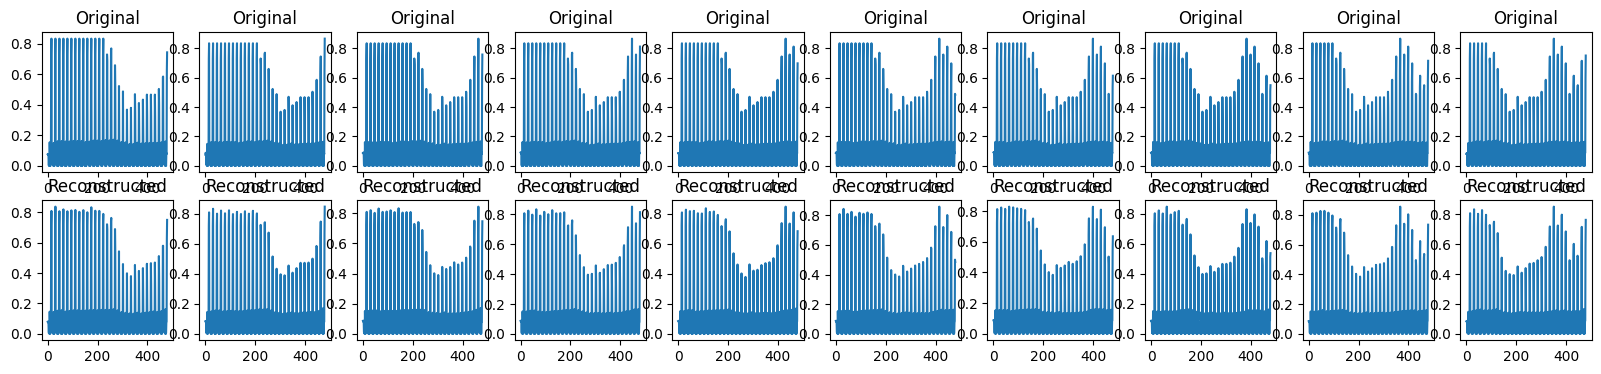

In [9]:
# 评估模型
test_loss = autoencoder.evaluate(x_test, x_test)
print(f"测试损失: {test_loss}")

# 重构和可视化
decoded_data = autoencoder.predict(x_test)
n = 10  # 可视化前10个样本
plt.figure(figsize=(20, 4))
for i in range(n):
    # 原始数据
    ax = plt.subplot(2, n, i + 1)
    plt.plot(x_test[i].reshape(-1))
    plt.title("Original")
    
    # 重构数据
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(decoded_data[i].reshape(-1))
    plt.title("Reconstructed")
plt.show()

In [10]:
history